In [1]:
import warnings
warnings.filterwarnings('ignore')
from itertools import product, combinations
import numpy as np
import scipy
from scipy.spatial.transform import Rotation as R
from scipy.optimize import minimize, basinhopping
import matplotlib
matplotlib.rcParams['figure.dpi'] = 140
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

In [2]:
class GeometricObject:
    """Abstract superclass defining a generic 3D geometric object with location, rotation, and scale.

    A GeometricObject is defined by its location in global cooridnates, rotation in Euler angles,
    and scale (all objects share the same scale). For all objects, location and rotation are 
    treated as optimizable, and scale is treated as fixed. To define a specific type of geometric 
    object (see class Cuboid below), the methods get_bounding_intervals and add_self_to_axis must be
    implemented. Sub-classes may have additional attributes.

    Attributes:
        loc: a length 3 np.array of form [loc_x, loc_y, loc_z].
        rot: a length 3 np.array of form [rot_x, rot_y, rot_z].
        scale: a length 3 np.array of form [scale_x, scale_y, scale_z].
    """
    def __init__(self, loc, rot, scale):
        """Init method.
        
        Args: 
            loc: list-like with form [X,Y,Z], object centroid coordinates.
            rot: list-like with form [X,Y,Z], object rotation in degrees.
            scale: list-like with form [X,Y,Z], object scale.
        Returns:
            None
        """
        self.loc = np.array(loc)
        self.rot = np.array(rot)
        self.scale = np.array(scale)

    def get_optimizable_attr(self):
        """Get the attributes that can be optimized in the form of a flat np.array.
        
        Generally, we assume location and rotation to be optimizable, and scale to be fixed.
        
        Args:
            None.
        Returns:
            A flat np.array with every optimizable attribute stacked together.
            It looks like [loc_x,loc_y,loc_z,rot_x,rot_y,rot_z].
        """
        return np.concatenate([self.loc, self.rot])

    def set_optimizable_attr(self, attr_array):
        """Set optimizable attributes with an np.array of the same form as one from get_optimizable_attr.

        The purpose of this method is to quickly convert an array generated by get_optimizable_attr and
        optimized by the scipy optimizer back to self.geometry.

        Args:
            attr_array: Flat np.array of same form as one returned by get_optimizable_attr.
        Returns:
            None. Modifies self.geometry.
        """
        self.loc = attr_array[:3]
        self.rot = attr_array[3:]

    def get_bounding_intervals(self):
        """Get the largest and lowest coordinate values along each dimension of the object as intervals.

        The purpose of this method is to easily get a "bounding box" in the form of three (along
        the X, Y, and Z axes) intervals that fully (and ideally tightly) bound the range of points
        spanned by the object. This way, regardless of the object's shape or orientation, we can
        get a cuboid bound that is always parallel to the global coordinate axes. Having this method
        makes constraints that rely on having the "leftmost" or "topmost" points aligned easier to write.

        Args:
            None.   
        Returns:
            A tuple of three lists ([x_min, x_max], [y_min, y_max], [z_min, z_max]) that bounds the object.
        """
        raise NotImplementedError

    def add_self_to_axis(self, ax, label, color):
        """Add self as a 3D wireframe shape with appropriate loc/rot/scale to an matplotlib axis.

        Args:
            ax: A matplotlib axis with projection set to 3D.
            label: A str, label to display in legend.
            color: A valid matplotlib color to use for this object's wireframe.
        Returns:
            A color patch with label to be passed to legend handler. Also modifies the input argument ax.
        """
        raise NotImplementedError

class Cuboid(GeometricObject):
    """A cuboid.

    Inherits from the GeometricObject abstract class. A cuboid is a unit cube by default,
    the location/rotation/size of which is determined by the object's loc/rot/scale.

    Attributes:
        Same as super-class, no additional attributes. Add additional attributes as needed.
    """
    def __init__(self, loc, rot, scale):
        super().__init__(loc, rot, scale)

    def get_bounding_intervals(self):
        """Get bounding intervals around the (possibly rotated) cuboid.

        See super-class documentation for specifics. Note that, for a cuboid, the bounding
        intervals will be perfectly tight if the cuboid is not rotated/rotated with right
        angles, but otherwise these intervals will be loose.
        """
        # get the corners first -> extreme points can only be corners
        corners = self.get_corners()

        # find the max and min along each dimension
        min_by_dim = corners.min(axis=0)
        max_by_dim = corners.max(axis=0)

        # collect into tuple of three lists and return
        return ([min_by_dim[0], max_by_dim[0]],
                [min_by_dim[1], max_by_dim[1]],
                [min_by_dim[2], max_by_dim[2]])
        
    def add_self_to_axis(self, ax, label, color):
        """Add self as 3D wireframe cuboid to ax.

        See super-class documentation for specifics. For a cuboid, we just draw a simple
        wireframe connecting all vertices.
        """
        # get the corners to draw wireframe on
        vertices = self.get_corners()

        # # generate all pairwise combinations of vertices for wireframe and plot only edges
        # for start, end in combinations(vertices, 2):
        #     l2_dist = np.linalg.norm(start - end)
        #     if (abs(l2_dist-self.scale_x) < 1e-4        # only plot the lines that are edges
        #         or abs(l2_dist-self.scale_y) < 1e-4     # identify edges if distance is close to scale
        #         or abs(l2_dist-self.scale_z) < 1e-4):   # 1e-4 tolerance added due to numerical inpercision
        #         ax.plot(*zip(start,end), color=color)

        # the above works, but does needless computation and is subject to numerical lack of precision
        # more direct method: just plot all twelve lines directly since get_corners returns corners in fixed order
        ax.plot(*zip(vertices[0],vertices[1]), color=color) # lower rectangle
        ax.plot(*zip(vertices[1],vertices[3]), color=color)
        ax.plot(*zip(vertices[3],vertices[2]), color=color)
        ax.plot(*zip(vertices[2],vertices[0]), color=color)
        ax.plot(*zip(vertices[4],vertices[5]), color=color) # upper rectangle
        ax.plot(*zip(vertices[5],vertices[7]), color=color)
        ax.plot(*zip(vertices[7],vertices[6]), color=color)
        ax.plot(*zip(vertices[6],vertices[4]), color=color)
        ax.plot(*zip(vertices[0],vertices[4]), color=color) # connecting upper and lower rectangles
        ax.plot(*zip(vertices[1],vertices[5]), color=color)
        ax.plot(*zip(vertices[2],vertices[6]), color=color)
        ax.plot(*zip(vertices[3],vertices[7]), color=color)

        # return a patch for legend
        return mpatches.Patch(color=color, label=label)
        

    def get_corners(self):
        """Get the corner vertices of the cuboid.

        Cuboid-specific helper method to faciliate plotting and bounding-interval finding.

        Args:
            None
        Returns:
            An np.array of shape (8,3) with all eight corners of the cuboid.
            NOTE: The corners are returned in default order of itertools.product([-0.5,0.5], [-0.5,0.5], [-0.5,0.5]).
        """
        # define base (unit-cube) corners
        corners = np.array(list(product([-0.5,0.5], [-0.5,0.5], [-0.5,0.5])))

        # get rotation matrix from Euler angles
        rotation_matrix = R.from_euler(angles=self.rot,
                                       seq="xyz", degrees=True).as_matrix()

        # transform base corners with loc, rot, and scale
        corners = corners * self.scale # scale
        corners = corners @ rotation_matrix # rotate
        corners = corners + self.loc # translate
        return corners

In [3]:
class ConstraintProposition:
    """Abstract superclass representing a proposition asserting the satisfaction of a constraint between given objects.

    All constraints should inherit from this class. A constraint proposition is a proposition asserting
    that some constraint (defined by the badness method) is satisfied on the given set of objects
    passed at initialization (stored in self.arguments) -- for example, given a sub-class IsAligned, 
    the initialization of that sub-class might look like IsAligned((cube1, cube2), kwargs) and represent
    the proposition that cube1 and cube2 are aligned. To define a new constraint, one only needs to
    implement the badness method (how badly is the constraint violated?) and the define_arity method (what is
    the arity of this proposition?).

    Attributes:
        arity: int or None, the arity of this proposition. None denotes flexible arity.
        arguments: list (length equals arity) of objects of class GeometricObject, the arguments to constrain.
    """
    def __init__(self, arguments):
        """Init method.
        
        Args: 
            arguments: A list-like of Object objects.   
        Returns:
            None
        Raises:
            ValueError if there is an arity mismatch.
        """
        self.arity = self.define_arity() # get the arity
        arguments = list(arguments) # ensure arguments is a list

        # check to make sure list has correct arity
        if self.arity is not None and len(arguments) != self.arity:
            raise ValueError(f"Input arguments has arity {len(arguments)}, but constraint was defined with arity {self.arity}.")

        # if it does, store as attribute
        self.arguments = arguments

    def define_arity(self):
        """Define the arity of the constraint proposition, i.e. length of self.arguments.

        THIS METHOD SHOULD RETURN EITHER AN INTEGER OR NONE. NONE denotes flexible
        arity (the badness method will, in that case, have to be written accordingly
        to process a whole list and cannot make assumptions about its length).

        Args:
            None.
        Returns:
            An integer or None denoting arity.
        """
        raise NotImplementedError
        
    def badness(self):
        """Compute the badness of satisfaction of this constraint.
        
        Each type of constraint will have a different definition for badness of satisfaction
        and so will each need to implement this method separately. Furthermore, this method
        only operates on attributes and must take no additional arguments. Any information
        other than self.arguments should be stored as additional attributes by __init__.
        
        Args:
            None. 
        Returns:
            A scalar float value indicating badness of satisfaction of this constraint by self.arguments.
        """
        raise NotImplementedError

class IsAligned(ConstraintProposition):
    """A proposition that represents a notion of translational alignment between objects.

    NOTE: This constraint proposition is flexible-arity. It can be instantiated with any
          number of arguments. The output is simply the mean absolute deviation along the
          specified dimension at the specified location.

    Inherits from the Object abstract class. Alignment is defined by the self.dimension and
    self.location attriutes. The former represents the dimension along which alignment should be
    considered, and the latter represents which part of the objects one wants aligned (the
    left-most point? The center? Etc.). For example, if one wishes to articulate the constraint
    that "the top-most points on the given objects are aligned", one would set dimension="Z"
    and location="bounding_max". If one wants to have the objects with centers aligned on the
    X-axis, one would set dimension="X" and location="center".

    Attributes:
        Superclass attributes.
        dimension: str, one of "x", "y", or "z", the dimension on which to assert alignment.
        location: str, one of "bounding_min", "bounding_max", or "center", where to check alignment.
    """
    def __init__(self, arguments, dimension, location):
        """Init method."""
        super().__init__(arguments)

        # check to make sure dimension and location are valid
        if dimension not in ["x", "y", "z"]:
            raise ValueError(f"Argument 'dimension' must be one of 'x', 'y', or 'z'.")
        if location not in ["bounding_min", "bounding_max", "center"]:
            raise ValueError(f"Argument 'dimension' must be one of 'bounding_min', 'bounding_max', or 'center'.")

        # store attributes
        self.dimension = dimension
        self.location = location

    def define_arity(self):
        """See superclass documentation for details."""
        return None # flexible-arity

    def badness(self):
        """See superclass documentation for details.
        
        In this case, badness is calculated as the mean absolute deviation between all objects
        passed along the specified dimension and location.
        """
        # convert str dimension to index
        dim_idx = 0
        if self.dimension == "x": dim_idx = 0
        elif self.dimension == "y": dim_idx = 1
        elif self.dimension == "z": dim_idx = 2

        # get values to compare for all objects
        values_to_compare = []
        for argument in self.arguments:
            if self.location == "bounding_min":
                values_to_compare.append(argument.get_bounding_intervals()[dim_idx][0])
            elif self.location == "bounding_max":
                values_to_compare.append(argument.get_bounding_intervals()[dim_idx][1])
            elif self.location == "center":
                values_to_compare.append(argument.loc[dim_idx])

        # take the mean absolute deviation and output
        values_to_compare = np.array(values_to_compare)
        return np.abs(values_to_compare - values_to_compare.mean()).mean()

In [4]:
class Problem:
    """The primary way users interact with the constraint solver.

    This class handles problem creation, adding optimizable objects and constraint propositions, solving
    the problem, and plotting the current state of all objects. Every optimizable object currently
    in the problem is given an id by the user code on addition. Any object not added to the problem
    is treated as constant and immovable.

    NOTE: When adding constraint propositions between optimizable objects, it is recommended to use the
          function get_optimizable_object with the desired object's id to prevent confusion. Any objects
          that are not explicitly id-ed and added through add_optimizable_object but are mentioned in
          any of the constraint propositions is treated as immovable.

    Attributes:
        optimizable_objects: A dictionary of GeometricObjects that are optimizable, each with a unique id.
        constraint_propositions: A list of ConstraintPropositions between GeometricObjects that we want to satisfy.
        constraint_weights: A list of floats representing the weight of each constraint proposition at the same idx.
    """
    def __init__(self):
        """Create an empty problem."""
        self.optimizable_objects = {}
        self.constraint_propositions = []
        self.constraint_weights = []

    def add_optimizable_object(self, object, id):
        """Add a GeometricObject to self.optimizable_objects with given id.
        Args:
            object: A GeometricObject to be added.
            id: The id to identify the object with.
        Returns:
            None.
        Raises:
            ValueError if an object with id is already in self.optimizable_objects.
        """
        if id in self.optimizable_objects:
            raise ValueError(f"The id passed ({id}) is already associated with an object in the problem.")
        self.optimizable_objects[id] = object

    def remove_optimizable_object(self, id):
        """Remove an GeometricObject from self.optimizable_objects by id.
        Args:
            id: The id to of the object to remove.
        Returns:
            None.
        Raises:
            ValueError if id passed is not present in self.optimizable_objects.
        """
        if id not in self.optimizable_objects:
            raise ValueError(f"The id passed ({id}) is not associated with any object in the problem.")
        self.optimizable_objects.pop(id)

    def get_optimizable_object(self, id):
        """Get pointer to an GeometricObject from self.optimizable_objects by id.
        Args:
            id: The id to of the object to get.
        Returns:
            A pointer to the desired object.
        Raises:
            ValueError if id passed is not present in self.optimizable_objects.
        """
        if id not in self.optimizable_objects:
            raise ValueError(f"The id passed ({id}) is not associated with any object in the problem.")
        return self.optimizable_objects[id]

    def add_constraint_proposition(self, proposition, weight):
        """Add a new ConstraintProposition to the problem.
        Args:
            proposition: The constraint proposition to add.
            weight: The weight of this constraint proposition.
        Returns:
            None.
        """
        self.constraint_propositions.append(proposition)
        self.constraint_weights.append(weight)

    def _flatten_optimizable_parameters(self):
        """Helper function to flatten the optimizable parameters of all optimizable objects for scipy."""
        arrays = []
        for id, object in self.optimizable_objects.items():
            arrays.append(object.get_optimizable_attr())
        return np.concatenate(arrays)

    def _recover_optimizable_parameters(self, flat_array):
        """Helper function to recover the optimizable parameters of all optimizable objects given flat array.
        NOTE: flat_array has to be one originally outputted by _flatten_optimizable_parameters."""
        obj_len = len(next(iter(self.optimizable_objects.values())).get_optimizable_attr())
        cur = 0
        for id, object in self.optimizable_objects.items():
            object.set_optimizable_attr(flat_array[cur:cur+obj_len])
            cur = cur + obj_len

    def solve(self):
        """Tune the optimizable parameters of all optimizable objects to best satisfy constraint propositions.
    
        This is the main function of the solver. It modifies objects in place.
    
        Args:
            None.
        Returns:
            None. Modifies self.optimizable_objects in-place.
        """
        def objective(flat_array):
            # update the objects
            self._recover_optimizable_parameters(flat_array)

            # compute the total weighted badness measure for all constraint propositions
            total_badness = 0
            for i in range(len(self.constraint_propositions)):
                total_badness += (self.constraint_propositions[i].badness() * self.constraint_weights[i])
            return total_badness

        # compute solution, changing objects every iteration along the way
        solution = basinhopping(objective, x0=self._flatten_optimizable_parameters(), niter=100)

        # set the objects to the final solution
        self._recover_optimizable_parameters(solution.x)

    def plot(self, fixed_axes=None, elev=30, azim=40):
        """Plot the problem with all optimizable objects shown.

        This generates a 3D plot.

        Args:
            fixed_axes: If not None, all x/y/z-lims will be set to (-fixed_axes,fixed_axes).
            elev, azim: matplotlib 3D plot viewing angle.
        Returns:
            None. Shows the plot.
        """
        # create figure
        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")

        # define colors
        colors = list(mcolors.TABLEAU_COLORS.keys())

        # add all objects to ax
        legend_patchs = []
        color_idx = 0 # will wrap around
        for id, object in self.optimizable_objects.items(): 
            legend_patchs.append(object.add_self_to_axis(ax, label=id, color=colors[color_idx]))
            color_idx += 1
            color_idx = color_idx % len(colors)

        # configure plot info
        ax.set_title("All Optimizable Objects in Problem")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.legend(handles=legend_patchs)
        ax.set_xlim(-fixed_axes,fixed_axes)
        ax.set_ylim(-fixed_axes,fixed_axes)
        ax.set_zlim(-fixed_axes,fixed_axes)

        #configure view
        ax.set_proj_type("persp",focal_length=0.2)
        ax.view_init(elev=elev,azim=azim)
        plt.show()

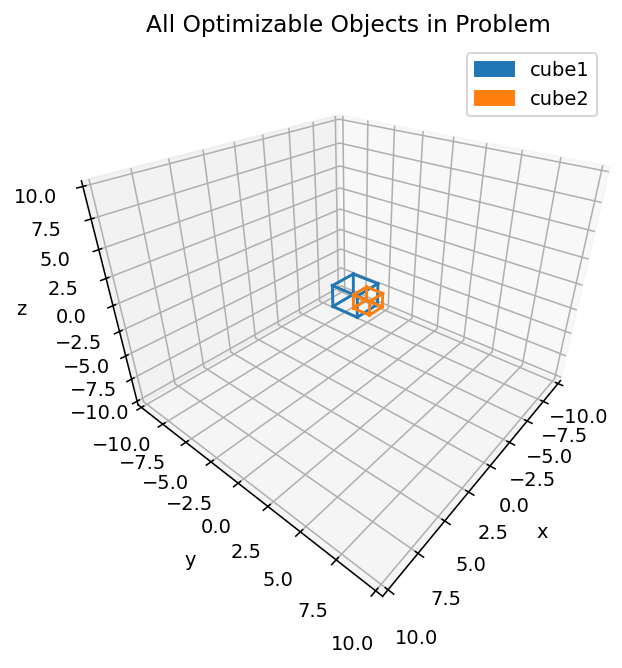

Cube 1 initial coordinates: [0 0 0]
Cube 2 initial coordinates: [5 5 5]


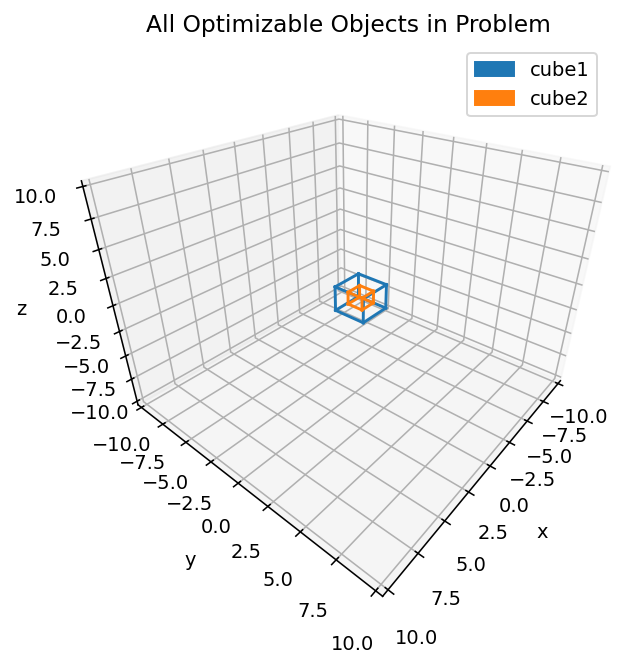

Cube 1 final coordinates: [2.5 2.5 2.5]
Cube 2 final coordinates: [2.5 2.5 2.5]


In [6]:
problem = Problem()

# add objects
cube1 = Cuboid(loc=[0,0,0], rot=[0,0,0], scale=[2,2,2])
problem.add_optimizable_object(cube1, "cube1")
cube2 = Cuboid(loc=[5,5,5], rot=[0,0,0], scale=[1,1,1])
problem.add_optimizable_object(cube2, "cube2")

# plot initial state
problem.plot(fixed_axes=10)
print(f"Cube 1 initial coordinates: {cube1.loc}")
print(f"Cube 2 initial coordinates: {cube2.loc}")

# add constraint propositions
problem.add_constraint_proposition(IsAligned(arguments=(cube1,cube2),
                                             dimension="x",
                                             location="center"), weight=1)
problem.add_constraint_proposition(IsAligned(arguments=(cube1,cube2),
                                             dimension="y",
                                             location="center"), weight=1)
problem.add_constraint_proposition(IsAligned(arguments=(cube1,cube2),
                                             dimension="z",
                                             location="center"), weight=1)

# solve
problem.solve()

# plot final state
problem.plot(fixed_axes=10)
print(f"Cube 1 final coordinates: {cube1.loc}")
print(f"Cube 2 final coordinates: {cube2.loc}")

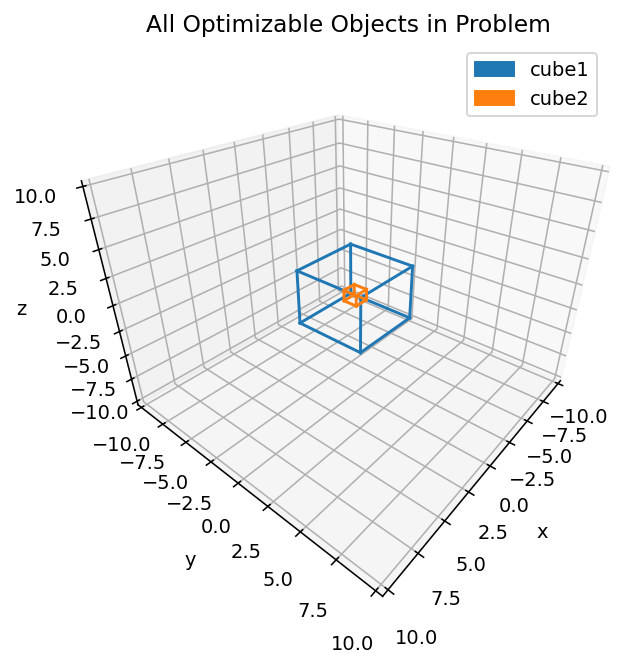

Cube 1 initial coordinates: [0 0 0]
Cube 2 initial coordinates: [0 0 0]


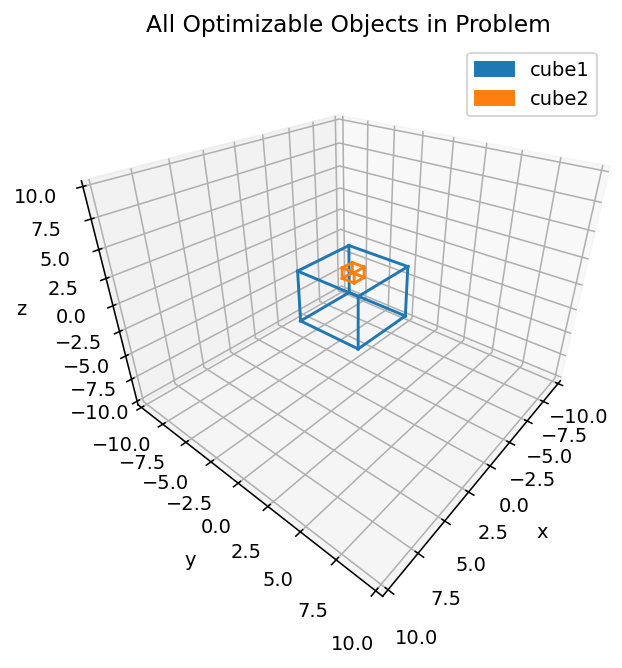

Cube 1 final coordinates: [-1.06266214 -1.06266214 -1.06266214]
Cube 2 final coordinates: [-1.06266214 -1.06266214  1.06266214]


In [8]:
problem = Problem()

# add objects
cube1 = Cuboid(loc=[0,0,0], rot=[0,0,0], scale=[5,5,5])
problem.add_optimizable_object(cube1, "cube1")
cube2 = Cuboid(loc=[0,0,0], rot=[0,0,0], scale=[1,1,1])
problem.add_optimizable_object(cube2, "cube2")

# plot initial state
problem.plot(fixed_axes=10)
print(f"Cube 1 initial coordinates: {cube1.loc}")
print(f"Cube 2 initial coordinates: {cube2.loc}")

# add constraint propositions
problem.add_constraint_proposition(IsAligned(arguments=(cube1,cube2),
                                             dimension="x",
                                             location="center"), weight=1)
problem.add_constraint_proposition(IsAligned(arguments=(cube1,cube2),
                                             dimension="y",
                                             location="center"), weight=1)
problem.add_constraint_proposition(IsAligned(arguments=(cube1,cube2),
                                             dimension="z",
                                             location="bounding_max"), weight=1)

# solve
problem.solve()

# plot final state
problem.plot(fixed_axes=10)
print(f"Cube 1 final coordinates: {cube1.loc}")
print(f"Cube 2 final coordinates: {cube2.loc}")